<a href="https://colab.research.google.com/github/JacopooOrsinii/Project1_LSTM_for_reviews/blob/main/Project1_LSTM_for_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: LSTM for reviews

In this project I aim to implement 3 forms of embeddings (Word2Vec, festtext and glove) to combine them to train a classifier, in particular a version of the LSTM will be implemented. The goal of the analysis is to classify positive (3-4-5 stars) and negative (1-2 stars) reviews based on the review content.

## 1. Loading the necessary packages and files

In this first part of the first Task we are going to download all the packages required to implement all the tasks. From the website https://amazon-reviews-2023.github.io/ we can donload different datasets related to amazon products, divided according to the category they refer to. In this case, I decided to work on the dataset related to the Gift cards.

In [ ]:
! pip install --quiet "pandas" "ipython[notebook]" "torchvision" "setuptools==59.5.0" "torch>=1.8" "torchmetrics>=0.7" "seaborn" "pytorch-lightning>=1.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.18.0 requires setuptools>=60.0.0, but you have setuptools 59.5.0 which is incompatible.


In [ ]:
import requests
import json
from google.colab import files
import zipfile
import os
import gzip
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

from gensim.models import Word2Vec
from gensim.models import FastText

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torchmetrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# The Gift_Card file is downloaded from the related link
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Gift_Cards.jsonl.gz

--2024-08-23 15:20:23--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Gift_Cards.jsonl.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12556849 (12M) [application/x-gzip]
Saving to: ‘Gift_Cards.jsonl.gz’

Gift_Cards.jsonl.gz 100%[===================>]  11.97M  12.5MB/s    in 1.0s    

2024-08-23 15:20:25 (12.5 MB/s) - ‘Gift_Cards.jsonl.gz’ saved [12556849/12556849]



In [ ]:
# The file names are defined
gz_file_name = "Gift_Cards.jsonl.gz"
jsonl_file_name = "Gift_Cards.jsonl"

# With this code the .gz file existence is checked and later on, the .gz file is decompressed
if os.path.exists(gz_file_name):

    with gzip.open(gz_file_name, 'rt', encoding='utf-8') as gz_file:
        with open(jsonl_file_name, 'w') as jsonl_file:
            jsonl_file.write(gz_file.read())

# With this code we verify if the decompressed file exists
if os.path.exists(jsonl_file_name):
    # Here a small function to display in a nice way the JSON file is created
    def pprint(x):
        print(json.dumps(x, indent=2)) if isinstance(x, dict) else display(x)

    # Wit this code the first element from the JSONL file is read and pretty print
    with open(jsonl_file_name, 'r') as fp:
        for line in fp:
            pprint(json.loads(line.strip()))
            break

    # Loading of the JSONL file into a pandas DataFrame
    df = pd.read_json(jsonl_file_name, lines=True)

    # Display the DataFrame
    df.head()

{
  "rating": 5.0,
  "title": "Great gift",
  "text": "Having Amazon money is always good.",
  "images": [],
  "asin": "B00IX1I3G6",
  "parent_asin": "B00IX1I3G6",
  "user_id": "AHZ6XMOLEWA67S3TX7IWEXXGWSOA",
  "timestamp": 1549866158332,
  "helpful_vote": 0,
  "verified_purchase": true
}


Our DataFrame is displayed after removing all the column apart from the text column and the rating column which will be fundamental for the implementation of the LSTM model.

In [ ]:
df = df[['text','rating']]
df

,text,rating
0,Having Amazon money is always good.,5
1,Always the perfect gift. I have never given o...,5
2,When you have a person who is hard to shop for...,5
3,The tin is a nice touch and pretty large. It'...,5
4,I bought this pack of Starbucks Gift cards in ...,1
...,...,...
152405,I was really impressed with the pink bag. I g...,5
152406,Realmente es fascinante como hacen de algo muc...,5
152407,Hit accidentally,1
152408,Great,5


## 2. Preprocessing of the reviews

In this part of the Task we preprocess the reviews in order to clean them and have them ready to be passed inside the model. \
In particular the preprocessing steps we made are: \
- Tokenization: the input text is split into singular tokens
- Lowering: all the tokens are converted into lower case
- Removal of stopwords: the common english stopwords are filtered \

The output of this code will give us back the reviews cleaned.

In [ ]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowering and number/charaters removal
    cleaned_tokens = [token.lower() for token in tokens if token.isalpha()]
    # Removal of stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in cleaned_tokens if token not in stop_words]

    return filtered_tokens

# The preprocessing function is applied to the column "text" of the DataFrame df
df['text'] = df['text'].apply(preprocess_text)

# The column "text" is saved into the variable x
x = df["text"].to_numpy()

## 3. Embeddings

The word embeddings are at the base of our Task, they allow us to associate each word with a vector of numbers in order to have words with similar meanings mapped to similar vectors. In particular, we are going to implement 3 kinds of word embeddings that are: \
- Word2Vec
- Fasttext
- Glove

In [ ]:
# We download the glove.6B.zip file from the related link
!wget nlp.stanford.edu/data/glove.6B.zip

# We unzip the glove.6B.zip file
!unzip glove*.zip

# With this line of code we implement Word2vec
model1 = Word2Vec(x, min_count = 1, vector_size = 100, window = 3)

# With this line of code we imlement Festtext
ft_model = FastText(sentences=x, vector_size=100, window=5, min_count=1, workers=4)

# With this code we implement Glove
glove_vectors = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector

--2024-08-23 15:21:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-23 15:21:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-23 15:21:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## 4. Combining the embeddings

We have the 3 types of embedding and we want to concatenate them in a vector that will contain 300 numbers, 100 for each embedding we implemented. Before doing this, we create a list of unique words that contains 22.620 items; in this way we will have a dictionary that will have a list of 300 numbers associated to each unique word.

In [ ]:
# We create a list of unique words among all the reviews we have
all_tokens = [token for sublist in df['text'] for token in sublist]
unique_words = list(set(all_tokens))
print(len(unique_words))

22620


In [ ]:
# The concatenated_arrays list and word_vectors dictionary are initialised
concatenated_arrays = []
word_vectors = {}

# This code iterates over all the unique words and checks if it exists in the 3 models, eventually if a word doesn't exist in one of the 3 models,
# Then the missing space is fulifilled with 0s
for word in unique_words:
    model1_array = model1.wv[word] if word in model1.wv else np.zeros(100)
    ft_array = ft_model.wv[word] if word in ft_model.wv else np.zeros(100)
    glove_array = glove_vectors[word] if word in glove_vectors else np.zeros(100)

    # The 3 embeddings are concatenated and stored into the dictionary word_vector, with the word as key
    concatenated_array = np.concatenate((model1_array, ft_array, glove_array))
    concatenated_arrays.append(concatenated_array)
    word_vectors[word] = concatenated_array

# The list of concatenated arrays is converted to a numpy array
concatenated_arrays = np.array(concatenated_arrays)

print("Length of unique words list:", len(unique_words))
print("Length of concatenated arrays list:", len(concatenated_arrays))
print("Shape of concatenated arrays:", concatenated_arrays.shape)

Length of unique words list: 22620
Length of concatenated arrays list: 22620
Shape of concatenated arrays: (22620, 300)


In [ ]:
# This code shows the output of the concatenation for the word "good"
if "good" in word_vectors:
    good_vector = word_vectors["good"]
    print("Vector for 'good':", good_vector)
    print("Length of the vector for 'good':", len(good_vector))
else:
    print("The word 'good' is not in the vocabulary.")

Vector for 'good': [ 3.06913555e-01  4.95233476e-01  1.06586266e+00 -1.81407499e+00
 -3.34087282e-01 -1.14210176e+00  3.81376654e-01  1.28698087e+00
  4.90721077e-01 -1.95221364e+00  7.50095546e-01 -1.01210451e+00
  2.21712187e-01 -1.67001569e+00  5.25006473e-01  7.24472463e-01
  1.41669822e+00  2.45392293e-01  1.87344342e-01 -3.41501504e-01
 -7.02523172e-01  2.46042728e-01  6.60524428e-01 -2.85517782e-01
 -1.35736728e+00  1.04536510e+00 -3.11379023e-02 -7.71146953e-01
  1.83472544e-01  8.95776153e-01  4.36538041e-01 -5.48754036e-01
 -2.96843588e-01 -3.60394329e-01 -1.91489726e-01  1.12528312e+00
  9.24990237e-01 -1.29395694e-01 -1.26469171e+00 -4.67034906e-01
  8.65707934e-01 -1.82835847e-01 -1.55691072e-01  5.12041628e-01
  6.93251848e-01 -4.96486761e-02  5.84719419e-01 -1.25026202e+00
 -6.60094321e-01  1.91130608e-01  7.75618330e-02 -1.88208431e-01
  1.14601310e-02  1.88506639e-03 -9.62290391e-02 -4.00300264e-01
  8.34262967e-02  6.72182560e-01  3.65195066e-01 -1.94057822e-01
 -9.87

Here we displayed an example of how a vector of concatenated embeddings looks like, in this case for the word: good.

## 5. LSTM model

In [ ]:
# Part 6.1: Preparation of the Dataset
class ReviewDataset(Dataset):
    def __init__(self, df, word_vectors, max_len=20):
        self.df = df
        self.word_vectors = word_vectors
        # We set a max length of the reviews, they should be made of max 20 words otherwise there would be problems with shapes in input for the model,
        # it can work because most of the reviews have less than 20 words.
        self.max_len = max_len
        # We incude tye padding in order to have the inputs, all of the same size
        self.pad_vector = np.zeros(300)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        rating = self.df.iloc[idx]['rating']

        # Conversion of each review to list of embeddings, according to the scores contained in the dictionary word_vectors
        # a list comprehension is used to iterate over the words in the text list
        # For each word in the text, it checks if the word is present in the self.word_vectors dictionary
        embeddings = [self.word_vectors[word] if word in self.word_vectors else self.pad_vector for word in text]

        # In this code, all the reviews that don't respect the constraint of 20 words are truncated or padded
        if len(embeddings) > self.max_len:
            embeddings = embeddings[:self.max_len]
        else:
            embeddings.extend([self.pad_vector] * (self.max_len - len(embeddings))) # if the word is not found in the unique words vector, it is padded with all 0

        embeddings = np.array(embeddings)

        # The "rating" column is converted to 1 for positive (3, 4, 5), 0 for negative (1, 2)
        label = 1 if rating in [3, 4, 5] else 0

        return torch.tensor(embeddings, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [ ]:
dataset = ReviewDataset(df, word_vectors)

def print_sample_details(dataset, num_samples=5):
    for i in range(num_samples):
        embeddings, label = dataset[i]
        print(f"Sample {i}:")
        print(f"Embeddings: {embeddings}")
        print(f"Label: {label}")
        print(f"Shape of embeddings: {embeddings.shape}")
        print()

print_sample_details(dataset)

Sample 0:
Embeddings: tensor([[ 0.9969, -0.5672,  0.3184,  ...,  0.2627,  0.0030,  0.3442],
        [-0.6338,  0.5764, -1.4000,  ...,  0.3394,  0.7086,  0.2094],
        [ 0.0353,  0.4797,  0.1816,  ..., -0.7191,  0.0574,  1.0433],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
Label: 1
Shape of embeddings: torch.Size([20, 300])

Sample 1:
Embeddings: tensor([[ 0.0353,  0.4797,  0.1816,  ..., -0.7191,  0.0574,  1.0433],
        [-0.6260,  0.8910,  1.0234,  ..., -0.4153, -0.0880,  0.3027],
        [-0.1564, -0.0142,  1.2486,  ..., -0.2905,  0.3838,  0.2066],
        ...,
        [ 0.5669, -0.5363,  0.0459,  ..., -1.0084,  1.2093, -0.3332],
        [ 0.3124, -0.4774, -0.0151,  ..., -0.8858,  0.0754,  0.0404],
        [ 0.1876, -1.0436,  0.0632,  ...,  0.3785, -0.1505, -0.0407]])
Label: 1
Shape of embeddings: torch

In [ ]:
# Part 6.2: Creatig an LSTM Classifier
class CustomLSTMClassifier(pl.LightningModule):
    def __init__(self, input_dim=300, hidden_dim=128, output_dim=2, n_layers=3, bidirectional=False, dropout=0.2):
    # input_dim: number of features in input, in outr case 300, that corresponds to the dimension of the vector for each word
    # hidden_dim: = number of features in the hidden state
    # output_dim: number of classes for classification
    # n_layers: number of LSTM layers
    # bidirectional: wheather the LSTM is bidirectional
    # dropout: dropout rate for regularization
        super(CustomLSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = dropout

        # We define the weights and biases for the gates in the LSTM cell
        # For the 'forget' gate
        # torch.Tensor(input_dim + hidden_dim, hidden_dim): creates a tensor with dimensions 300+128, 128
        # nn.Parameters(): wraps the tensor into a nn.Parameter object

        # Forget gate
        self.Wf = nn.Parameter(torch.Tensor(input_dim + hidden_dim, hidden_dim)) # forget weights
        self.bf = nn.Parameter(torch.Tensor(hidden_dim)) # forget biases

        # Input gate
        self.Wi = nn.Parameter(torch.Tensor(input_dim + hidden_dim, hidden_dim)) # input gate weights
        self.bi = nn.Parameter(torch.Tensor(hidden_dim)) # input gate biases

        # Cell gate
        self.Wc = nn.Parameter(torch.Tensor(input_dim + hidden_dim, hidden_dim)) # cell gate weights
        self.bc = nn.Parameter(torch.Tensor(hidden_dim)) # cell gate biases

        # Output gate
        self.Wo = nn.Parameter(torch.Tensor(input_dim + hidden_dim, hidden_dim)) # ouput gate weights
        self.bo = nn.Parameter(torch.Tensor(hidden_dim)) # output gate weights and biases

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize weights
        self.init_weights()

        # Metrics
        self.accuracy = torchmetrics.Accuracy(task='binary', num_classes=output_dim)
        self.precision = torchmetrics.Precision(task='binary', num_classes=output_dim, average='macro')
        self.recall = torchmetrics.Recall(task='binary', num_classes=output_dim, average='macro')
        self.f1 = torchmetrics.F1Score(task='binary', num_classes=output_dim, average='macro')

    # A method is done to initialize the weights
    def init_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param) # Xavier is used to initialise a parameter if this parameter is multi-dimensional
            else:
                param.data.fill_(0.0)

    # The forward pass through the network is defined
    def forward(self, x):
        # We initiallize the hidden state
        h_t = torch.zeros(x.size(0), self.hidden_dim, device=self.device)
        # We initialize the cell state
        c_t = torch.zeros(x.size(0), self.hidden_dim, device=self.device)

        # the LSTM cell combines the input at the current time step with the previous hidden state to determne the new hidden state and cell state
        for t in range(x.size(1)): # iterates over each time step in the sequence
            x_t = x[:, t, :] # extracts the input at time step t for all elements in the batch
            combined = torch.cat((x_t, h_t), dim=1) # concatenates the input at time t with the previous hidden state

            f_t = torch.sigmoid(combined @ self.Wf + self.bf) # Forget state activation, matrix multiplication between combined and forget weights, then the forget biases are added
            i_t = torch.sigmoid(combined @ self.Wi + self.bi) # input gate activation
            g_t = torch.tanh(combined @ self.Wc + self.bc) # cell gate activation
            o_t = torch.sigmoid(combined @ self.Wo + self.bo) # output gate activation

            # New cell state and hidden state
            c_t = f_t * c_t + i_t * g_t # updates the cell state by combining the previous cell state and the current cell gate value, modulated for the forget and input gates
            h_t = o_t * torch.tanh(c_t) # updates the hidden state based on the new cell state and the output gate

        output = self.fc(h_t)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x) # performing the forward pass
        loss = self.loss_fn(y_hat, y) # calculating the loss

        y_prob = torch.softmax(y_hat, dim=1)
        y_pred = torch.argmax(y_prob, dim=1)

        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(y_pred, y))
        self.log('train_precision', self.precision(y_pred, y))
        self.log('train_recall', self.recall(y_pred, y))
        self.log('train_f1', self.f1(y_pred, y))

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)

        y_prob = torch.softmax(y_hat, dim=1)
        y_pred = torch.argmax(y_prob, dim=1)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(y_pred, y), prog_bar=True)
        self.log('val_precision', self.precision(y_pred, y), prog_bar=True)
        self.log('val_recall', self.recall(y_pred, y), prog_bar=True)
        self.log('val_f1', self.f1(y_pred, y), prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)

        y_prob = torch.softmax(y_hat, dim=1)
        y_pred = torch.argmax(y_prob, dim=1)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy(y_pred, y), prog_bar=True)
        self.log('test_precision', self.precision(y_pred, y), prog_bar=True)
        self.log('test_recall', self.recall(y_pred, y), prog_bar=True)
        self.log('test_f1', self.f1(y_pred, y), prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# Splitting the dataset into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4)
val_df, test_df = train_test_split(temp_df, test_size=0.5)

# Creating datasets and dataloaders
train_dataset = ReviewDataset(train_df, word_vectors)
val_dataset = ReviewDataset(val_df, word_vectors)
test_dataset = ReviewDataset(test_df, word_vectors)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

csv_logger = CSVLogger("logs", name="my_model")

# Defining the custom model, checkpoint, and early stopping callbacks
model = CustomLSTMClassifier()  # Using the custom LSTM classifier

checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

# Creation of the trainer
trainer = pl.Trainer(max_epochs=3, callbacks=[checkpoint_callback, early_stop_callback], logger=csv_logger)

# Training of the model
trainer.fit(model, train_loader, val_loader)

# Testing the model
trainer.test(model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | fc           | Linear           | 258    | train
1 | loss_fn      | CrossEntropyLoss | 0      | train
2 | accuracy     | BinaryAccuracy   | 0      | train
3 | precision    | BinaryPrecision  | 0      | train
4 | recall       | BinaryRecall     | 0      | train
5 | f1           | BinaryF1Score    | 0      | train
  | other params | n/a              | 219 K  | n/a  
----------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
6         Modules in train mode
0       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9499048590660095     │
│          test_f1          │    0.9719411730766296     │
│         test_loss         │    0.12565657496452332    │
│      test_precision       │    0.9679542183876038     │
│        test_recall        │    0.9768989682197571     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.12565657496452332,
  'test_acc': 0.9499048590660095,
  'test_precision': 0.9679542183876038,
  'test_recall': 0.9768989682197571,
  'test_f1': 0.9719411730766296}]

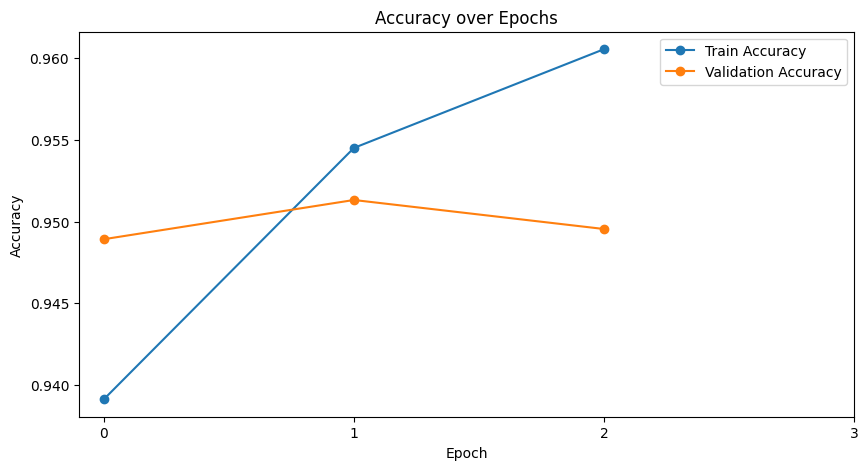

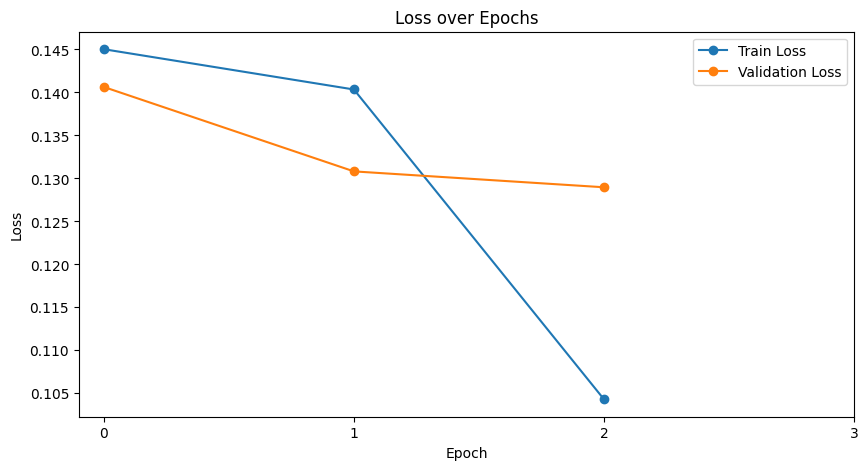

In [ ]:
# Part 6.4: Plot the Accuracy and Loss
metrics = pd.read_csv("logs/my_model/version_0/metrics.csv")

epoch_metrics = metrics.groupby('epoch').mean()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_metrics.index, epoch_metrics['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epoch_metrics.index, epoch_metrics['val_acc'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epoch_metrics.index)
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_metrics.index, epoch_metrics['train_loss'], label='Train Loss', marker='o')
plt.plot(epoch_metrics.index, epoch_metrics['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_metrics.index)
plt.legend()
plt.title('Loss over Epochs')
plt.show()